Realizado por Carlos Bohórquez y Mariangel Mantilla

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linprog
import cvxopt as cvx
import cvxpy as cp
from sklearn.linear_model import LinearRegression
from scipy import stats
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Punto 1

$$ \max_{\{ x_1,x_2 \} } 2 x_1 - x_2 $$
$$  x_1 + x_2 \geq 1 $$
$$ x_1 - x_2 \leq 0 $$
$$ 3 x_1 + x_2 \leq 6 $$
$$ x_1,\ x_2 \geq 0 $$

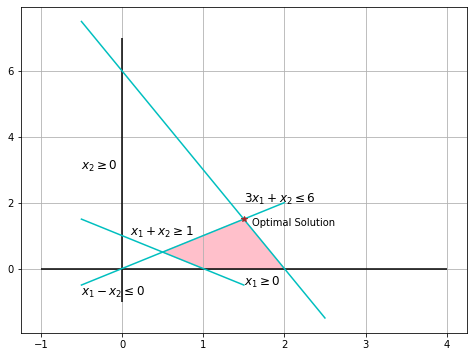

In [ ]:
from matplotlib.patches import Polygon
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()

# Draw constraint lines
ax.hlines(0, -1, 4)
ax.vlines(0, -1, 7)
ax.plot(np.linspace(-0.5, 1.5, 100), 1-1*np.linspace(-0.5, 1.5, 100), color="c")
ax.plot(np.linspace(-0.5, 2.5, 100), 6-3*np.linspace(-0.5, 2.5, 100), color="c")
ax.plot(np.linspace(-0.5, 2, 100), 0+1*np.linspace(-0.5, 2, 100), color="c")
ax.text(0.1, 1, "$x_1 + x_2 \geq 1$", size=12)
ax.text(1.5, 2, "$3 x_1 + x_2 \leq 6$", size=12)
ax.text(-0.5, -0.8, "$x_1 - x_2 \leq 0$", size=12)
ax.text(-0.5, 3, "$x_2 \geq 0$", size=12)
ax.text(1.5, -0.5, "$x_1 \geq 0$", size=12)

# Draw the feasible region
feasible_set = Polygon(np.array([[0.5, 0.5], 
                                 [1.5, 1.5], 
                                 [2, 0], 
                                 [1, 0]]), 
                       color="pink")
ax.add_patch(feasible_set)

#Solución óptima
ax.plot(1.5, 1.5, "*", color="brown")
ax.text(1.6, 1.3, "Optimal Solution", size=10);

Interpretación:


Para este punto tenemos un problema de programación lineal donde el principal objetivo es maximizar el valor de las dos variables X y X2 a traves de buscar el valor optimo de la funcion. Para esto desarrollamos la grafica anterior donde se establecen las restricciones que abarca el espacio de color rojo, en el cual se establece la region factible en el desarrollo del problema, donde tanto X y X2 alcanzaron valores maximos de 1,5. Siendo este el punto mas alto de la figura que representa la solucion más optima.



Punto 2

In [ ]:
#Con linprog
c = np.array([0.1,0.15,0.16,0.08]) #R esperado
A = np.array([[1,1,1,1]])
b = np.array([80])

D = np.array([[0.5,0.3,0.25,0.6],
              [0.3,0.1,0.4,0.2],
              [0.2,0.6,0.35,0.2]])
d = np.array([28,24,12])

resultado = linprog(-c,A_ub=-D,b_ub=-d,A_eq=A,b_eq=b, method='simplex')
resultado
#x.value

     con: array([0.])
     fun: -10.989473684210527
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([-3.55271368e-15, -3.55271368e-15,  1.60000000e+01])
  status: 0
 success: True
       x: array([ 0.        , 12.63157895, 46.31578947, 21.05263158])

In [ ]:
# Con cvxpy.
n = 4 #4 variables
x = cp.Variable(n)
c = np.array([0.1,0.15,0.16,0.08])
A = np.array([[1,1,1,1]]) #4 1s porque son 4 fondos
b = np.array([80])

D = np.array([[0.5,0.3,0.25,0.6],
              [0.3,0.1,0.4,0.2],
              [0.2,0.6,0.35,0.2]])
d = np.array([28,24,12])

objective = cp.Maximize(c.T @ x ) #El @ es para multiplicar matrices 
constraints = [D @ x >= d, A @ x  == b,  x>=0]#<> es de la funcion de desigualdad original 
prob = cp.Problem(objective, constraints)

#El objetivo optimo 
result = prob.solve()
# La solucion optima 
sol=round(pd.DataFrame(x.value),4)
sol

,0
0,0.0000
1,12.6316
2,46.3158
3,21.0526


Interpretación:

Ahora bien, para resolver este problema se busca seleccionar la mejor opción de inversion, donde se pretende maximizar la rentabilidad con respecto a la restriccion presupuestaria de 80 millones abarcando inversiones minimas en diferentes fondos. Con lo anterior, podemos ver que en el desarrollo del problema para maximizar la inverson los fondos tienen la siguiente asignación: para el primer fondo se le asigno una inversion de 0, el segundo fondo se le asigno una cantidad de 12,63 millones, ademas para el tercer fondo se le asigno 46,31 millones y por ultimo, para el cuarto fondo se le asigno una inversion de 21.05 millones. Es asi como se obtiene 10,98 millones de ganancia en maximización.



Punto 3

In [ ]:
#Construcción de vectores
b = np.array([150, 100, -200, 200, -50, -300])
c = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1]) #Función objetivo
rx = np.array([1.01])  #tasa del crédito
ry = np.array([1.02]) #Tasa del bono
rz = np.array([1.003]) #Tasa excedente
A = np.array([[1,0,0,0,0, 1,0,0, -1,0,0,0,0,0],
              [-rx,1,0,0,0, 0,1,0, rz,-1,0,0,0,0],
              [0,-rx,1,0,0, 0,0,1, 0,rz,-1,0,0,0],
              [0,0,-rx,1,0, -ry,0,0, 0,0,rz,-1,0,0],
              [0,0,0,-rx,1, 0,-ry,0, 0,0,0,rz,-1,0],
              [0,0,0,0,-rx, 0,0,-ry, 0,0,0,0,rz,-1]])

#Solución con cvxpy
n = len(c) # # de elementos que requiere el vector c
x = cp.Variable(n) #Mismo tamaño de c porque se debe operar x con c

objective = cp.Maximize(c.T @ x )
constraints = [A @ x == b, x>=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
sol = round(pd.DataFrame(x.value),4)
sol

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


,0
0,0.0000
1,42.6867
2,0.0000
3,0.0000
4,8.4595
5,150.0000
6,57.3133
7,195.0578
8,0.0000
9,0.0000


In [ ]:
#Solución con linprog
resultado = linprog(-c,A_eq=A,b_eq=b, method="simplex")
resultado

     con: array([ 0.00000000e+00,  1.42108547e-14, -2.84217094e-14,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
     fun: -92.4969491525423
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([  0.        ,  50.98039216,   0.        ,   0.        ,
         0.        , 150.        ,  49.01960784, 203.43436358,
         0.        ,   0.        , 351.9441675 ,   0.        ,
         0.        ,  92.49694915])

Interpretación:  
Se maximiza el exceso de fondos en el mes 6, que para este caso es equivalente a 92,4969.  
Se utilizaron 2 optimizadores diferentes y, a pesar de tener resultados ligeramente diferentes, ambos resultados son óptimos, y la diferencia en respuestas se debe al optimizador utilizado.  
Además, se observa que el resultado final es el mismo en ambos casos.

Punto 4

In [ ]:
#Seleccion de activo y factores
fechainicial = "2016-12-01"
fechafinal = "2021-12-31"
periodicidad = "1Mo"
activos = ["TM"]
p_ejercicio = yf.download(activos,start=fechainicial,end=fechafinal,interval=periodicidad)['Adj Close'].dropna()
r_ejercicio = np.log(p_ejercicio/p_ejercicio.shift(1)).dropna()

indice1 = yf.download("^GSPC",start=fechainicial,end=fechafinal,interval=periodicidad)['Adj Close'].dropna()
r_indice1 = np.log(indice1/indice1.shift(1)).dropna()

indice2 = yf.download("SLX",start=fechainicial,end=fechafinal,interval=periodicidad)['Adj Close'].dropna()
r_indice2 = np.log(indice2/indice2.shift(1)).dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
slope, intercept, r, p, std_err = stats.linregress(r_indice1, r_ejercicio)
def linestim(x):
  return intercept + slope * x

model = list(map(linestim, r_indice1))




In [ ]:
lm = LinearRegression()
model = lm.fit(pd.DataFrame(r_indice1), pd.DataFrame(r_ejercicio))
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [0.00087282]
betas = [[0.53696369]]


In [ ]:
slope, intercept, r, p, std_err = stats.linregress(r_indice2, r_ejercicio)
def linestim(x):
  return intercept + slope * x

model = list(map(linestim, r_indice2))

In [ ]:
lm = LinearRegression()
model = lm.fit(pd.DataFrame(r_indice2), pd.DataFrame(r_ejercicio))
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [0.0052892]
betas = [[0.29052271]]


In [ ]:
t = len(r_indice1)
unos = pd.DataFrame(np.repeat(1,t))
r_indice3 = pd.DataFrame(r_indice1)
r_indice4=pd.DataFrame(r_indice2)
r_ejercicio2 = pd.DataFrame(r_ejercicio)

variables = np.concatenate((unos,r_indice3,r_indice4),1)
X = variables.T @ variables

Xy = variables.T @ r_ejercicio2

Solucion= np.linalg.solve(X,Xy)
Solucion

array([[0.00291266],
       [0.25233799],
       [0.19129071]])

Interpretación:

Para iniciar hay que tener en cuenta las variables seleccionadas para el desarrollo del problema, para eso seleccionamos el activo Toyota Motor Corporation (TM). Adicionalmente, seleccionamos el indice Standar & Poor´s 500 (GSPC) y VanEck Steel ETF (SLX) como variables o factores que pueden intervenir en la variabilidad del activo, lo cual va hacer dmeostrado por: 

β̂ = Q −1b = (X TX) −1XTy

Con lo anterior, se realizo la estimacion lineal del activo y los indices para tener como resultado los valores que corresponden al rendimiento con respecto a los factores (Aplha) y el riesgo del activo (Beta). 

**Aplha**
Para este caso, podemos establecer que las correlaciones del activo TM para los dos factores GSPC y SLX mantienen valores positivos, siendo 0.00087 para GSPC y 0.00528 para SLX, por lo que podemos afirmar que el rendimiento del activo TM fue mayor que las que se obtuvieron en el mercado.

**Beta**
Como resultado de los modelos establecidos (indice 1) se puede apreciar una correlacion positiva del activo seleccionado TM y GSPC con un movimiento de 0.53 pp, por otro lado si vemos la correlacion entre el activo TM y el segundo factor SLX este solo tiene una variacion de 0.29 pp. Con todos podemos decir que el activo seleccionado no mantiene un comportamiento volatil en el mercado con respecto a los factores utilizados, por lo que en ninguno de los dos casos el activo es agresivo. 

Con respecto a las estimaciones realizados en los mercados con respecto a los factores y la estimacion MCO podemos ver como resultado que para el activo TM mantiene un rendimiento positivo pero por debajo de las de los factores, siendo de 0.002 y una variacion de 0.25 de GSPC y 0.19 para SLX. Por lo que podemos concluir, que tanto para el indice de Standar & Poor´s y VanEck Steel ETF Toyota Motor Corporation existe una correlacion notoria para los dos.




Punto 5

In [ ]:
b = np.array([100, 200, 800, 100, 800, 1200])
c = np.array([109, 94.8, 99.5, 93.1, 97.2, 92.9, 110, 104, 102, 95.2, 0, 0, 0, 0, 0, 0])
A = np.array([[10, 7, 8, 6, 7, 5, 10, 8,7,100, -1, 0, 0, 0, 0, 0],
              [10, 7, 8, 6, 7, 5, 10, 8, 7, 0, 1, -1, 0, 0, 0, 0],
              [10, 7, 8, 6, 7, 5, 110,108,0,0, 0, 1, -1, 0, 0, 0],
              [10, 7, 8, 6, 7, 105, 0, 0, 0,0, 0, 0, 1, -1, 0, 0],
              [10, 7, 8, 106, 107, 0, 0,0,0,0, 0, 0, 0, 1, -1, 0],
              [110, 107, 108, 0, 0, 0,0,0,0,0, 0, 0, 0, 0, 1, -1]])


#Solución con cvxpy
n = len(c) # # de elementos que requiere el vector c
x = cp.Variable(n) #Mismo tamaño de c porque se debe operar x con c

objective = cp.Minimize(c.T @ x )
constraints = [A @ x >= b, x>=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
sol = round(pd.DataFrame(x.value),4)
sol

,0
0,0.0000
1,11.2150
2,0.0000
3,6.6338
4,0.0000
5,0.0000
6,0.0000
7,6.0087
8,-0.0000
9,0.0000



Interpretación:

En este caso, para el desarrollo de este problema planteamos 3 matrices b, c, A 
donde b representa los precios actuales, c los requerimientos y A abarca a los bonos emitidos por los gobiernos teniendo en cuenta los exedentes de efectivo que pueden transferirse en los años. Para minimizar el costo y garantizar que el flujo de efectivo sea suficiente para cubrir el requerimiento del fondo, se elabora la solucion del problema en cvx donde x que abarca las 10 primeras filas seria el portafolio con el menor costo, las 6 filas restantes hacen parte del residuo, es decir la diferenci entre el saldo a favor menos el requerimiento.



